#### Introduction

Welcome to your Refinitiv Hackathon. This notebook is intended to be a quick start guide to help you get your data as easily as possible. 

Once you have logged into Eikon or Workspace you can get started coding very easily by launching the CODEBOOK APP by typing CODEBK into the search bar or launcher. This wiil spin up a new instance with all the python libraries we have available. 

#### Now how to go about finding data?

For the best experience we recommend the CODE CREATOR app or the DATA ITEM BROWSER app. These tools can help you navigate the wealth of content you have access to in Eikon:

|Category               |Category                       |Category                       |
|:----------------------|:------------------------------|:------------------------------|
|Real Time              |Reference & Identifiers        |Issuer Level Credit Ratings    |
|Price & Volume         |IBES Estimates                 |Starmine Models & Analytics    |
|Corporate Actions      |Mergers & Acquisitions         |Events                         |
|Mutual Fund Holdings   |Equity Index Information       |Economic Indicators            |
|Lipper Funds           |Gov/Corp Bonds                 |US Munis                       |
|MBS                    |CMO/ABS Tranche                |Single Name CDS                |
|Index CDS              |Commodities/Physical Assets    |Warrants                       |
|Ownership              |Portfolio                      |Fundamentals                   |
|Timeseries Data        |Activism & Defence             |Deals                          |
|ESG Data               |Exchange Traded Products       |Prop Data                      |
|Company Fundamentals   |Sales/Trading Calc Analytics   |Private Equity                 |
|Stock Reports Plus     |Financial Markets Master       |                               |

**plus news - please see section on those API calls below**

#### COVID-19 Data

Our Covid-19 data is conveniently stored in a set of real-time economic indicator RICs. 
There are a 5 types of measures, Active Cases, Total Cases, Deaths, New Cases, Recovered. Each of these can be accessed by different country or regions. The easiest way is to look at the MACROVIT app. 

The five types of data are ACOV, CCOV, DCOV, NCOV, RCOV respectively. They are prefixed by either country or region codes and suffixed by =ECI.

So to get data for Italy our RICs would be: ITACOV=ECI, ITCCOV=ECI, ITDCOV=ECI, ITNCOV=ECI, ITRCOV=ECI

To get global data our RICS would be XWACOV=ECI, XWCCOV=ECI, XWDCOV=ECI, XWNCOV=ECI, XWRCOV=ECI

To get the codes for any country or region just use the MACROVIT app and update the main chart with the country or region you want then you will see the 2 digit code to use. 

#### Economic Data

Please see this [article](https://developers.refinitiv.com/en/article-catalog/article/using-economic-indicators-with-eikon-data-api-a-machine-learning-example) about finding and using economic timeseries

#### How to go about finding Instruments?

Its really easy to build up lists of instruments simply using the search bar. Refinitiv also maintains a series of chain RICs that can be used to call futures and options chains as well as Index constituents. For example, the RIC for the FTSE-100 index is .FTSE. In order to get the constituents for that index just put a 0# infront of the index eg. 0#.FTSE. In this way you can very quickly build larger coverage lists.

#### Putting it all together

Above we have covered getting a list of instruments and also list of fields. So lets get started by building some datasets using our APIs.


In [1]:
import refinitiv.dataplatform.eikon as ek
import refinitiv.dataplatform as rdp
import datetime
from IPython.display import HTML
import numpy as np
import pandas as pd
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')
rdp.open_desktop_session('DEFAULT_CODE_BOOK_APP_KEY')

Lets get some covid-19 TimeSeries data using the get_timeseries API call - note for Economic Timeseries we do not put a field into the API call:

In [ ]:
df = ek.get_timeseries(['ITACOV=ECI', 'ITCCOV=ECI', 'ITDCOV=ECI', 'ITNCOV=ECI', 'ITRCOV=ECI'],
                       start_date='2020-02-01',end_date='2021-05-19',interval='daily',)
df

Pretty straightforward - however we do apply API limits to each call - you can see those limits detailed [here](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation). In short limits per API call are as follows:

Datapoints returned per request - A datapoint is a 'cell', or a unique field value for a unique instrument on a unique time stamp. Datapoint limits vary by the content set being retrieved (for example, timeseries limits are different from news headline limits), but all are throttled on a per request basis and are not aggregated across all applications. Here are Datapoint limit examples per Eikon Data API function type 

**get_data**: The current limit value (10-Oct-2019) is around **10,000 data points**. 

**get_timeseries**: The current limit value (10-Oct-2019) is **3,000 data points (rows) for interday intervals** and **50,000 data points for intraday intervals**. This limit applies to the whole request, whatever the number of requested instrument.

**get_news_headlines**: The current limit value (10-Oct-2019) is **100 headlines per request**. The depth of history is 15 month.

**get_news_story**: The current limit value (10-Oct-2019) is **1 story per request**.

**get_symbology**: **No enforced limit** (10-Oct-2019).

Daily Limits

**Requests per day** - The number of requests sent to the platform per day via the Eikon Data APIs cannot exceed this limit. This number of requests is counted across all client applications connected to the same Eikon instance.The current limit value (10-Oct-2019) is **10,000 requests per day**.

**Response volume per day** - The volume (size) of data retrieved from the platform per day cannot exceed this limit. This volume of data is counted across all client applications connected to the same Eikon instance.The current limit value (10-Oct-2019) is **5 GB per day**.

#### Getting data from Eikon/Workspace
Therefore we have to employ iterative API calls if we want to build larger dataframes whilst staying within API call limits. Here we will build a list of closing prices for the FTSE-100 for the last 10 years. As the get_timeseries call does not accept chain RICs we will first get the constituents of the FTSE-100 using a chain RIC and a get_data function.

#### Get constituents of an Index

In [ ]:
ricList, err = ek.get_data('0#.NDX','CF_NAME')
ricList

#### get_timeseries loop with error handling
We can now use the instrument column of the dataframe as a list to iterate over for our get_timeseries API call. The get_timeseries data model only provides Open,High,Low,Close,Volume,Count fields. Here we just request a close.

In [ ]:
import time
instruments = ricList['Instrument'].astype(str).values.tolist()
#instruments = ['.SPX','.FTSE','.FTMIB']
s = '2018-01-06'
e = '2020-10-13'
inv = 'daily'

data1 = pd.DataFrame()

for i in instruments:
    succeed = False
    while succeed == False:
        try:
            df1 = ek.get_timeseries(i,  # RICs
                fields=['CLOSE'],  # fields to be retrieved
                start_date=s,  # start time
                end_date=e,  # end time
                interval=inv)
            df1.rename(columns = {'CLOSE': i}, inplace = True)
            if len(data1):
                data1 = pd.concat([data1, df1], axis=1)
            else:
                data1 = df1
            succeed = True
        except:
            time.sleep(0.1)
        else:
            break
    else:
        var = "p"
data1

In [ ]:
instruments = ricList['Instrument'].astype(str).values.tolist()
data1 = pd.DataFrame()
for i in instruments:
    try:
        df1 = rdp.get_historical_price_summaries(universe = i,
                                   interval = rdp.Intervals.DAILY, 
                                   start=datetime.datetime(2018, 1, 6, 0, 0),    
                                   end=datetime.datetime(2020, 10, 13, 0, 0),      
                                   fields = ['TRDPRC_1'])
        df1.rename(columns = {'TRDPRC_1': i}, inplace = True)
        if len(data1):
            data1 = pd.concat([data1, df1], axis=1)
        else:
            data1 = df1
    except:
        pass
data1

In [ ]:
data1.to_excel("rdptest3.xlsx")

#### Geting fundamental data (estimates in this case)
Next lets have a look at getting some estimate data for say 'VOD.L'. All fundamental fields can be accessed using the get_data API call. This API also accepts chain RICs as a parameter. However, we may still want to process RICs individually to avoid running into data limits.

In [ ]:
df, err = ek.get_data('VOD.L',fields = 
                      ["TR.ICBSector","TR.RevenueMean.calcdate","TR.RevenueMean","TR.EBITMean","TR.PreTaxProfitMean",
                       "TR.NetProfitMean","TR.EPSMean","TR.DPSMean",'TR.AnalyticEnergyUse(SDate=0,EDate=-4,Period=FY0,Frq=FY)','TR.PRICECLOSE'],
                      parameters={'SDate':'2020-10-10','EDate':'2020-09-01','Period':'FY1','Frq':'D'})

df

In [ ]:
df['Calc Date']=pd.to_datetime(df['Calc Date'])
df.set_index('Calc Date',inplace=True)
df.sort_values(by=['Calc Date'],ascending=True,inplace=True)
df

In [ ]:
%matplotlib inline
df[['Revenue - Mean','Price Close']].plot(subplots=True, figsize=(12,10))

#### get_news_headlines & get_news_story API calls

Eikon carries 15 months worth of News that you can retrieve via API. The first API call to use is get_news_story and this requires a query term at minimum and returns a maximum of 100 headlines per API call. The query can be generated using the NEWS Monitor app (type NEWS into eikon search bar). This returns a dataframe containing the news headlines from the query along with the storyID which provides access to the underlying story text, using the get_news_story API call. In the example below I calculate the maximum historical range for the news (-15 months, maxenddate) and can then iterate updating the start date from the minimum date contained in the returned news dataframe, as I progress, upto our maxenddate.

In [ ]:
import datetime
from datetime import datetime
import dateutil.relativedelta
now = datetime.now()
maxenddate = now - dateutil.relativedelta.relativedelta(days=2) #months,days
print(now, maxenddate)

In [ ]:
newsdf = pd.DataFrame()
startdf=now
while startdf >= maxenddate:
    try:
        df1 = ek.get_news_headlines(query ='R:CLc1 AND Language:LEN', date_to = startdf, count=100)
        startdf = df1['versionCreated'].min().replace(second=0,microsecond=0,tzinfo=None).strftime('%Y/%m/%d %H:%M')
        startdf = datetime.strptime(startdf,'%Y/%m/%d %H:%M')
        if len(df1):
            newsdf = pd.concat([newsdf, df1], axis=0)
        else:
            newsdf = df1
    except Exception:
        break

newsdf.info()

So we now have our dataframe full of news articles - we can now get the story text for each article by iterating over the frame. **BEWARE: The get_news_story API only allows 1 storyID per API call. You are only allowed 10k API calls per day in total- your key cannot be reset until the next day - so BE CAREFUL HOW YOU USE THEM!**

In [ ]:
newsdf

In [ ]:
df3 = ek.get_news_story(newsdf['storyId'][0])
HTML(df3)

In [ ]:
isins = ['NL0009767532','US88160R1014']
ek.get_symbology(isins,from_symbol_type='ISIN',to_symbol_type='RIC')

#### [Search](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow)
The Search API is a powerful tool to extract content within the Refinitiv ecosystem including data such as instruments, quotes, bonds, organizations, people and much more.  The Refinitv Data Library for Python provides an ease-of-use interface to specify and extract content within a universe of logical views.  The interface exposes a rich set of properties and syntax with google-like familarity to more detailed expresseions to refine results.

The following example will use a simple query string to extract IBM bonds.

In [ ]:
rdp.search("IBM bonds")

The above example is a very simple way to use search to get a sense of what it can do and what it will provide.  Using a simple google-like query string, search will locate all documents that relate to IBM bonds within the entire data universe.  The above request uses a number of default parameters such as number of hits returned and what data to show for each.  Although not shown, the total number of matches the above query found was approximately 3300 hits.

While this is useful, you will soon discover that the ~3300 matches includes hits that aren't related to specific bonds or bonds that are inactive or have expired.  This is where we can provide more powerful search criteria to filter out unwanted data using logical expressions.  Search offers the ability to control what we want to match to and which properties we would like to return.  For example, the following expression will retrieve the list of active bonds that have not matured for IBM.  In here, I can control where to specifically look within the universe, i.e. the **View**, and using a more accurate **filter** expression to search against properties as well as **selecting** the fields to return.

In [ ]:
rdp.search(
    # The 'view' represents a specific domain of content we wish to search across.  
    view = rdp.SearchViews.GovCorpInstruments,
    
    # The 'filter' parameter is a powerful, criteria-based, syntax that allows us to filter for specific results.
    filter = "IssuerTicker eq 'IBM' and IsActive eq true and not(AssetStatus in ('MAT'))",

    # Look at the top 10 only.  The service defines a system imposed maximum value of 10000 documents.
    top = 10,

    # The 'select' parameter determines the fields of interest in our output.
    select = "ISIN, Currency, FaceIssuedTotal, EOMAmountOutstanding, CouponRate, MaturityDate, MainSuperRIC, PermID"
)

#### [DataStream](https://product.datastream.com/dsws/1.0/DSLogon.aspx?AppGroup=DSAddin&env=PROD&persisttoken=true&redirect=https%3a%2f%2fproduct.datastream.com%2fbrowse%2fsearch.aspx%3fAppGroup%3dDSAddin&srcapp=fast&srcappver=4.7.160.5783) Python Tutorial

Below is information about how to use DataStream in Python. It only covers the basics. It comes from the [DataStream Web Service API page on the Developer Advocacy website](https://developers.refinitiv.com/en/api-catalog/eikon/datastream-web-service/Tutorials#dsws-python-tutorial).

The purpose of this Tutorial is to demonstrate an example of one of the DSWS API delivery methods (namely the Python API) and lead to useful [case studies](https://developers.refinitiv.com/en/search-results?q=Datastream).

DSWS provides a [Python API](https://pypi.org/project/DatastreamDSWS/) to access Datastream content. This document describes how one may import DatastreamDSWS and use it - along with its parameters.

 

### Table of contents
- Basic Process Steps
    - Credentials
    - Import DSWS
    - Authentification
    - Requests
    - Get_data
- Use Case Articles
 

### Basic Process Steps

#### Credentials
1st, you will need Datastream DSWS credentials. Please note that these are **most often different from your Eikon/Workspace** credentials and can be found in your 'Welcome to Refinitiv' email.

#### Import DSWS
To import DSWS into your code, use the below:

In [ ]:
import DatastreamDSWS as dsws

#### Authentification
To use DSWS, you will need to authenticate yourself to the service. To do so, simply use the Python function Datastream from the DatastreamDSWS library as below, replacing 'DSWSusername' and 'DSWSpassword' with your own DSWS credentials. Remember that we imported it as dsws:

In [ ]:
ds = dsws.Datastream(username,password)

The above creates a Python object already connected to DSWS with which one can request for data.


#### Requests

You may now request data from DSWS. For help on each of the functions available, you may use the native Python help function:

In [ ]:
help(ds)

#### Get_data

You may now request for data via - for example - get_data. E.g.: you may request for quarterly US GDP for the year 2010 and retrieve a [Pandas data-frame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [ ]:
df=ds.get_data(tickers="USGDP...D",fields="X",start='2010-01-01',end='2011-01-01',freq='Q')
df

To find the field needed, please visit [product.datastream](http://product.datastream.com/DswsClient/Docs/Default.aspx), and navigate to the [series](https://product.datastream.com/dsws/1.0/DSLogon.aspx?AppGroup=DSAddin&env=PROD&persisttoken=true&redirect=https%3a%2f%2fproduct.datastream.com%2fbrowse%2fsearch.aspx%3fAppGroup%3dDSAddin&srcapp=fast&srcappver=4.7.141.5741), where you can search for your dataset of choice. In the above example, I searched for 'USA GDP' and used the Mnemonic of the 1st result.

In the screenshot [here](https://developers.refinitiv.com/en/api-catalog/eikon/datastream-web-service/Tutorials#dsws-python-tutorial), the Mnemonic is circled in red, the fields of choice in blue, and the highest frequency available in green.

### Use Case Articles

For more examples and explanations, please visit related articles in the [Academic](https://developers.refinitiv.com/en/use-cases-catalog/economic-econometric1), [Economic and Econometric](https://developers.refinitiv.com/en/use-cases-catalog/economic-econometric) or [Sustainable Finance](https://developers.refinitiv.com/en/use-cases-catalog/sustainable-investing) use-case [landing pages](https://developers.refinitiv.com/en/use-cases-catalog). We also have a multi-part tutorial series looking into how to use DatastreamDSWS with CodeBook [here](https://developers.refinitiv.com/en/article-catalog/article/estimating-monthly-gdp-via-the-expenditure-approach-and-the-holt-winters-model) if you are interested.

### Putting It All Together I - Widgets

You can use widgets to make an app like workflow in a Jupyter Notebook. These types of tools are often used in POC appps to show some functionality and how it could work as a bonafide app. They are quite powerful and have many different widget types: 

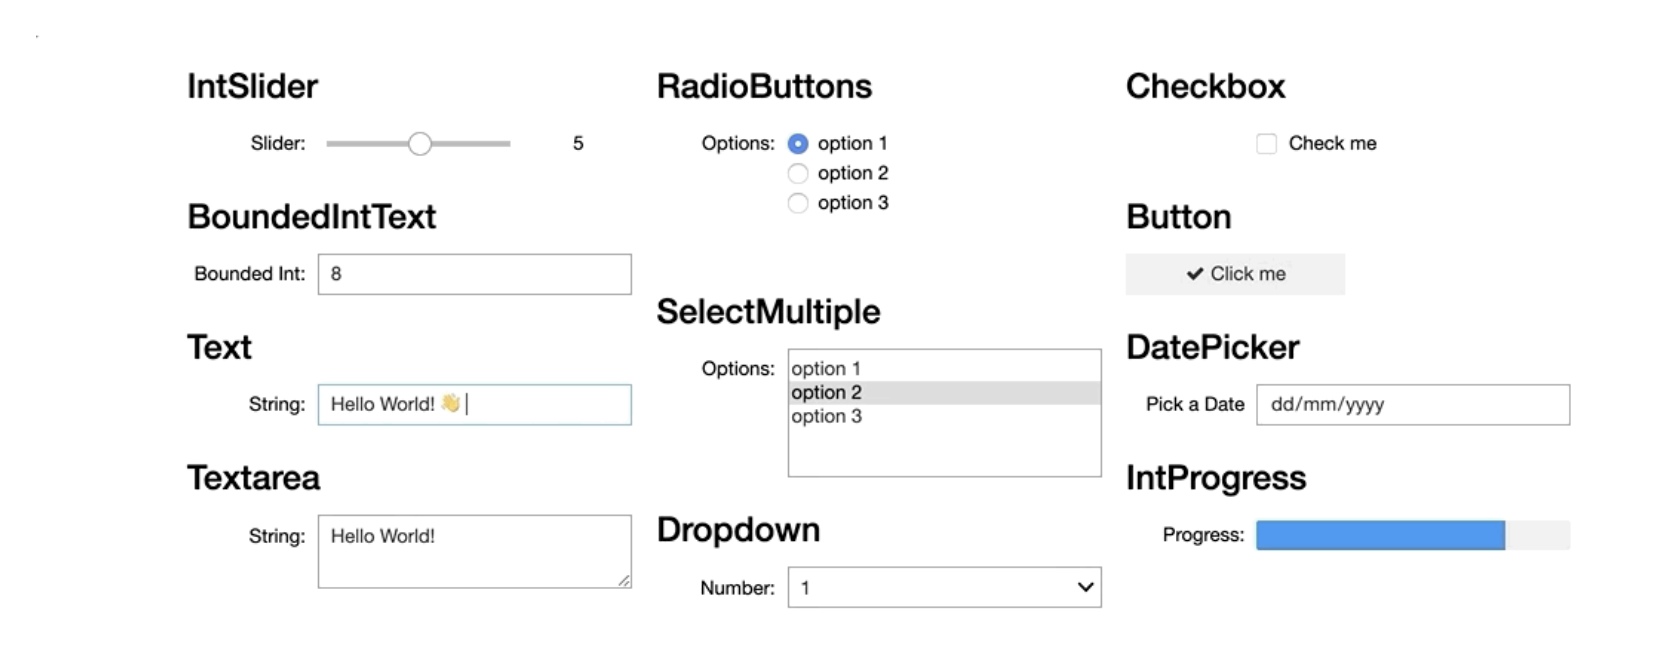

In [8]:
import ipywidgets as widgets
from ipywidgets import Box
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
rSel = widgets.Dropdown(
    options=['BRKa','VOD.L', 'BAC', 'TSLA.O'],
    value='VOD.L',
    description='RIC:',
    disabled=False,
)

yrSel = widgets.Text(
    value='-10',
    placeholder='Type something',
    description='# Periods:',
    disabled=False
)

freq = widgets.Dropdown(
    options=['FY', 'FS', 'FQ', 'FH'],
    value='FQ',
    description='Freq:',
    disabled=False,
)

curn = widgets.Dropdown(
    options=['USD', 'EUR', 'GBP', 'JPY'],
    value='USD',
    description='Currency:',
    disabled=False,
)

items = [rSel, yrSel, freq, curn]
box = Box(children=items)

box

In [ ]:
df,err = ek.get_data(rSel.value,['TR.SecurityOwnedName','TR.InvestorSharesHeld','TR.InvestorValueHeld.date','TR.InvestorValueHeld','TR.InvestorFilingDate'],
           parameters={'SDate':'0','EDate': yrSel.value,'Curn': curn.value,'Scale':'6','Frq': freq.value})
df.dropna(how='any',inplace=True)
df['Investor Filing Date'] = pd.to_datetime(df['Investor Filing Date'])
df.set_index('Investor Filing Date',inplace=True)
df.sort_index()
stockdf = df.groupby(by=['Security Owned Name'])
holdingslist = df['Security Owned Name'].unique()
dropholdings = widgets.Dropdown(options = holdingslist,disabled=False)
holdingRIC = widgets.Output()

def dropholdings_eventhandler(change):
    holdingRIC.clear_output()
    with holdingRIC:
            stockdf.get_group(change.new)['Investor Based Shares Held'].plot()
            
dropholdings.observe(dropholdings_eventhandler, names='value')
display(dropholdings)

### Putting It All Together II - Jupyter Dash

Jupyter Dash is an app framework that allows you to create fully functional apps, with a suite of components much like the widgets we saw and we can create much more complex standalone apps that can be hosted inline in a cell r even in a browser. As you can expect the technical complexity is higher than widgets but once you understand the basics you will quickly advance. 

In [3]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [13]:
app = JupyterDash(__name__)

#Initial API calls
uni, err = ek.get_data(["0#.DJI"], fields = ['TR.CommonName'] )
sl = uni.Instrument.astype(str).values.tolist()
slric=sl[0]

df = ek.get_timeseries(slric, fields=['CLOSE'], start_date='01-01-2021', interval='daily') #Price History

app.layout = html.Div([
    html.H1("JupyterDash App Sample"),
    html.Label([
        "ric",
        dcc.Dropdown(
            id='universe', clearable=False,
            value=sl[0], options=[
                {'label': c, 'value': c}
                for c in sl
            ])
    ]),
    dcc.Graph(id='graph')
    
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("universe", "value")]
)

def update_figure(value):
    df = ek.get_timeseries(value, fields=['CLOSE'], start_date='01-01-2021', interval='daily')
    fig = px.line(df, x=df.index.astype(str), y="CLOSE", title='Closing Price')
   
    return(fig)

In [14]:
# Run app and display result inline in the notebook
app.run_server(mode="inline")

I hope this is of use - beware of the API limits - and Happy Hacking :) 

[@jas0nram](https://twitter.com/jas0nram)